# DCN Goodreads Recommendation System

---
## Prepare the data

Setup

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '1'

In [2]:
import tensorflow as tf

import os

def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())



2022-02-17 14:34:17.829942: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-02-17 14:34:17.836152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 14:34:17.836169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We are using Tensorflow version 2.8.0
MKL enabled : True


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-02-17 14:34:27.083515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 14:34:27.083689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-17 14:34:27.083829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-17 14:34:27.087114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-02-17 14:34:27.087265: W tensorflow/stream_executor/platform/default/dso_loader

Dataset Directory

In [5]:
MODEL_DIR = './models/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
DIR = './data/cleaned/'

In [6]:
data = pd.read_pickle(os.path.join(DIR, "joined_df.pkl"))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981705 entries, 5e212a62bced17b4dbe41150e5bb9037 to e25d87abdb0bddcda1193034e54f819e
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             981705 non-null  object 
 1   book_id             981705 non-null  uint32 
 2   rating              981705 non-null  uint8  
 3   review_text         981705 non-null  string 
 4   title               981705 non-null  string 
 5   text_reviews_count  981705 non-null  uint64 
 6   average_rating      981705 non-null  float64
 7   description         981705 non-null  string 
 8   author_id           981705 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(1), uint64(1), uint8(1)
memory usage: 64.6+ MB


In [8]:
# only use small subset for test
data = data.iloc[:100000, :]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 5e212a62bced17b4dbe41150e5bb9037 to e77d4ff5fb4bb5c03f97912e834f75a8
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  object 
 1   book_id             100000 non-null  uint32 
 2   rating              100000 non-null  uint8  
 3   review_text         100000 non-null  string 
 4   title               100000 non-null  string 
 5   text_reviews_count  100000 non-null  uint64 
 6   average_rating      100000 non-null  float64
 7   description         100000 non-null  string 
 8   author_id           100000 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(1), uint64(1), uint8(1)
memory usage: 6.6+ MB


In [10]:
# train_data_file = "train_data.csv"
# test_data_file = "test_data.csv"
# alternatively, read the separated train/test files for repeatability
# train_data.to_csv(os.path.join(DIR, train_data_file), index=False)
# test_data.to_csv(os.path.join(DIR, test_data_file), index=False)

Let's split the data into training (70%), validation (15%) and test (15%) sets.

In [11]:
TARGET_FEATURE_NAME = "rating"  # individual rating
train_split = 0.7
test_val_split = 0.15 
seed = 42
np.random.seed(seed)

In [12]:
train_data, val_data, test_data = np.split(data.sample(frac=1, random_state=seed), 
                       [int(train_split*len(data)), int((1-test_val_split)*len(data))])
# splits into data[:train_split], data[train_split:test_split], data[test_split:]
print(f"Train split size: {len(train_data.index)}")
print(f"Validation split size: {len(val_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 70000
Validation split size: 15000
Test split size: 15000


Now about 980k in Total, Train: 687k, Validation, Test: 147k :)

In [13]:
CSV_HEADER = list(train_data.columns)

---
## Define dataset metadata
Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.



In [14]:
TARGET_FEATURE_LABELS = [i for i in range(6)]
# normalization
NUMERIC_FEATURE_NAMES = [
    "text_reviews_count",   # popularity
    "average_rating"
]
# text vectorization + embedding
TEXT_FEATURE_NAMES = [
    "review_text",
    "title",
    "description",
]
# integer lookup
CATEGORICAL_INT_FEATURE_NAMES = [
    "book_id",
    "author_id",
]
# string lookup
CATEGORICAL_STR_FEATURE_NAMES = [
    "user_id",
]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(data["user_id"].unique()),
    "author_id": list(data["author_id"].unique()),
    "book_id": list(data["book_id"].unique()),
}


FEATURE_NAMES = CATEGORICAL_STR_FEATURE_NAMES + \
                CATEGORICAL_INT_FEATURE_NAMES + \
                TEXT_FEATURE_NAMES
# FEATURE_NAMES = NUMERIC_FEATURE_NAMES + \
#                 TEXT_FEATURE_NAMES + \
#                 CATEGORICAL_INT_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]


NUM_CLASSES = len(TARGET_FEATURE_LABELS)

Adapt Text Vectorization Layers to the vocabular of the input dataset

In [15]:
print(" unique users: ", len(CATEGORICAL_FEATURES_WITH_VOCABULARY["user_id"]))
print(" unique books: ", len(CATEGORICAL_FEATURES_WITH_VOCABULARY["book_id"]))

 unique users:  40969
 unique books:  691


---
## Experiment setup
Next, let's define an input function that reads and parses the file, then converts features and labels into a `tf.data.Dataset` for training or evaluation.



In [16]:
def get_dataset_from_pandas(dataframe, label_name, batch_size, shuffle=False):
    df = dataframe.copy()
    labels = df.pop(label_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
from email_callback import EmailCallback
dropout_rate = 0.1

hidden_units = [32, 32]
EmailCallback()

def run_experiment(model, loss=None, metrics=None, learning_rate=0.001, batch_size=128, num_epochs=20):
    import datetime
    _loss = loss if loss is not None else [keras.losses.SparseCategoricalCrossentropy()]
    _metrics = metrics if metrics is not None else [keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseCategoricalCrossentropy()]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=_loss,
        metrics=_metrics,
    )

    train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_pandas(val_data, TARGET_FEATURE_NAME, batch_size)

    log_dir = "logs/fit/" + model.name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    email = EmailCallback(train_size=len(train_data), val_size=len(val_data))
    callbacks_train = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5),
        tf.keras.callbacks.BackupAndRestore(backup_dir="./models/backup"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        email
    ]

    print("Start training the model...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs, 
        callbacks=callbacks_train,
        validation_data=validation_dataset)
    print("Model training finished")

    print(metrics)

    return history, metrics


setting up yagmail...


In [18]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


---
## Create model inputs
Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a `keras.layers.Input` tensor with the corresponding feature shape and data type.



In [19]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in [*TEXT_FEATURE_NAMES, *CATEGORICAL_STR_FEATURE_NAMES]:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
    return inputs

---
## Encode features

We create two representations of our input features: sparse and dense: 1. In the *sparse* representation, the categorical features are encoded with one-hot encoding using the `CategoryEncoding` layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the *dense* representation, the categorical features are encoded with low-dimensional embeddings using the ``Embedding`` layer. This representation helps the model to generalize well to unseen feature combinations.



In [20]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [21]:
from tensorflow.keras.layers import StringLookup, IntegerLookup

call = 1
def encode_inputs(inputs, use_embedding=False):
    global call
    call += 1
    encoded_features = []
    for feature_name in inputs:
        if feature_name in [*CATEGORICAL_STR_FEATURE_NAMES, *CATEGORICAL_INT_FEATURE_NAMES]:
            is_string = (feature_name in CATEGORICAL_STR_FEATURE_NAMES)
            lookup_class = StringLookup if is_string else IntegerLookup
            lookup_name = "string_lookup" if is_string else "integer_lookup"
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = lookup_class(
                vocabulary=vocabulary,
                output_mode="int" if use_embedding else "multi_hot",
                name=f"{lookup_name}_{feature_name}_{call}",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary)+1, output_dim=embedding_dims,
                    name=f"{lookup_name}_embedding_{feature_name}_{call}",
                )
                
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        elif feature_name in TEXT_FEATURE_NAMES:
            vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features, 
            output_sequence_length=sequence_length if use_embedding else None, output_mode="int" if use_embedding else "multi_hot",
            name=f"textvectorization_{feature_name}_{call}",
            )
            vectorize_layer.adapt(data[feature_name])
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = vectorize_layer(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=vectorize_layer.vocabulary_size()+1, output_dim=embedding_dims,
                    name=f"tv_embedding_{feature_name}_{call}",
                )
                # average the embedding from sequence_length x batch to 1x32
                averaging = tf.keras.layers.GlobalAveragePooling1D();

                # Convert the index values to embedding representations.
                encoded_feature = averaging(embedding(encoded_feature))
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = vectorize_layer(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)
        
    all_features = layers.concatenate(encoded_features)
    return all_features


---
Pre-Compute Input (Embeddings)

In [22]:
# model_inputs = create_model_inputs()
# model_features = encode_inputs(model_inputs)
# embedded_features = encode_inputs(model_inputs, use_embedding=True)

---
## create query and candidate models

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding

BookModel / CandidateModel

In [24]:
class BookModel(tf.keras.Model):
    def __init__(self, use_embeddings = False):
        super().__init__()
        self.encoding = encode_inputs
        self.use_embeddings = use_embeddings
    def call(self, inputs):
        return self.encoding(inputs, use_embedding=self.use_embeddings)


UserModel / QueryModel

In [25]:
class UserModel(tf.keras.Model):
    def __init__(self, vocabulary, use_embeddings=False, embedding_dims=32):
        super().__init__()
        self.use_embeddings = use_embeddings
        lookup = StringLookup(
            vocabulary=vocabulary,
            output_mode="int" if self.use_embeddings else "multi_hot",
            name=f"string_lookup_user_id",
        )
        if self.use_embeddings:
            self.user_embedding = Sequential([
                lookup,
                Embedding(
                input_dim=len(vocabulary)+1, output_dim=embedding_dims,
                name=f"string_lookup_embedding_user_id",)
            ])
        else:
            self.user_embeddings = lookup

    def call(self, inputs):
        if not self.use_embeddings:
            # Convert the string input values into a one hot encoding.
            return self.user_embedding(tf.expand_dims(inputs['user_id'], -1))
        return self.user_embedding(inputs['user_id'])


Instantiate Models and save them

In [46]:
user_model = UserModel(CATEGORICAL_FEATURES_WITH_VOCABULARY['user_id'], use_embeddings=True)
book_model = BookModel(use_embeddings=True)

In [ ]:
user_model.save(os.path.join(MODEL_DIR, "user_model" + datetime.datetime.now().strftime("%Y%m%d")))
book_model.save(os.path.join(MODEL_DIR, "book_model" + datetime.datetime.now().strftime("%Y%m%d")))

---
## TFRS Model

### HP Tuning

In [ ]:
# Initialize the `HyperParameters` and set the values.
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = build_model(hp)
# Test if the model runs with our data.
model(train_data[:100])
# Print a summary of the model.
model.summary()


In [42]:
import keras_tuner as kt

HP_NUM_HIDDEN = hp.Int("units", min_value=1, max_value=4, step=1)
HP_HIDDEN_SIZE = hp.Discrete([32, 128, 256, 512])
)
HP_LR = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
METRIC_ACCURACY = 'accuracy'


AttributeError: module 'tensorboard.plugins.hparams.api' has no attribute 'Int'

In [58]:
from tqdm.notebook import tqdm
max_text_tokens=20_000
max_len = {
    "description": 100,
    "review_text": 200,
    "title": 10,
}
TEXT_FEATURE_VECTORIZATIONS = dict()
print("adapting text vectorizations to vocabulary data...")
for feature_name in tqdm(TEXT_FEATURE_NAMES):
    vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_text_tokens, output_sequence_length=max_len[feature_name], name=f"textvectorization_{feature_name}")
    vectorize_layer.adapt(data[feature_name])
    TEXT_FEATURE_VECTORIZATIONS[feature_name] = vectorize_layer

adapting text vectorizations to vocabulary data...


  0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
import tensorflow_recommenders as tfrs


class GoodreadsDCNModel(tfrs.models.Model):

    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None, embedding_dim=32, max_text_tokens=20_000):
        super().__init__()
        self.embedding_dimension = embedding_dim

        self._all_features = FEATURE_NAMES
        self._embeddings = {}

        # Compute embeddings for string features.
        for i, feature_name in enumerate(CATEGORICAL_STR_FEATURE_NAMES):
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.StringLookup(
                    vocabulary=vocabulary, mask_token=None, name=f"str_lookup_{feature_name}_{i}"),
                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                           self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                 ])
        # Compute embeddings for complex text features.
        for i, feature_name in enumerate(TEXT_FEATURE_NAMES):
            self._embeddings[feature_name] = tf.keras.Sequential([
                tf.keras.layers.TextVectorization(max_tokens=max_text_tokens, name=f"textvectorization_{feature_name}_{i}"),
                 tf.keras.layers.Embedding(max_text_tokens, self.embedding_dimension,  mask_zero=True, name=f"embedding_{feature_name}_{i}"),
                 tf.keras.layers.GlobalAveragePooling1D(),
                 ])

        # Compute embeddings for int features.
        for i, feature_name in enumerate(CATEGORICAL_INT_FEATURE_NAMES):
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.IntegerLookup(
                    vocabulary=vocabulary, mask_token=None, name=f"int_lookup_{feature_name}_{i}"),
                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                           self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                 ])

        # TODO use continuous numerical features

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
                             for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def adapt_text_vec(self, feature_name:str, data):
        self._embeddings[feature_name].layers[0].adapt(data)

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)

        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop(TARGET_FEATURE_NAME)
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )


In [68]:
def setup_model(use_cross_layer, deep_layer_sizes, no_dl, projection_dim=None):
  import datetime
  import tensorflow_addons as tfa
  from tqdm.notebook import tqdm

  deep_layers = np.repeat(deep_layer_sizes, no_dl)
  model = GoodreadsDCNModel(use_cross_layer=use_cross_layer,
              deep_layer_sizes=deep_layers,
              projection_dim=projection_dim)
  print("adapting text vectorization layers to vocabulary..")
  for feature_name in tqdm(TEXT_FEATURE_NAMES):
    model.adapt_text_vec(feature_name, data[feature_name])

  return model

In [69]:
def run_model(model, lr, epochs, batch_size, optimizer=tf.keras.optimizers.Adam):
  import datetime
  import tensorflow_addons as tfa

  model.compile(
      optimizer=optimizer(learning_rate=lr),
  )

  train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True).map(lambda x, y: {
    "book_id": x["book_id"],
    "author_id": x["author_id"],
    "user_id": x["user_id"],
    "review_text": x["review_text"],
    "title": x["title"],
    "description": x["description"],
    "rating": y,
  })
  validation_dataset = get_dataset_from_pandas(val_data, TARGET_FEATURE_NAME, batch_size).map(lambda x, y: {
    "book_id": x["book_id"],
    "author_id": x["author_id"],
    "user_id": x["user_id"],
    "review_text": x["review_text"],
    "title": x["title"],
    "description": x["description"],
    "rating": y,
  })
  test_dataset = get_dataset_from_pandas(test_data, TARGET_FEATURE_NAME, batch_size).map(lambda x, y: {
    "book_id": x["book_id"],
    "author_id": x["author_id"],
    "user_id": x["user_id"],
    "review_text": x["review_text"],
    "title": x["title"],
    "description": x["description"],
    "rating": y,
  })

  log_dir = "logs/fit/" + model.name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  email = EmailCallback(train_size=len(train_data), val_size=len(val_data))
  tqdm_callback = tfa.callbacks.TQDMProgressBar()
  callbacks_train = [
      tf.keras.callbacks.TensorBoard(log_dir=log_dir),
      tf.keras.callbacks.EarlyStopping(patience=3),
      tf.keras.callbacks.BackupAndRestore(backup_dir="./models/backup"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
      tqdm_callback
      # email
  ]

  print("Start training the model...")
  
  
  history = model.fit(
      train_dataset, 
      epochs=epochs, 
      callbacks=callbacks_train,
      validation_data=validation_dataset, verbose=0)
  print("Model training finished")
  metrics = model.evaluate(test_dataset, return_dict=True, callbacks=[tqdm_callback], verbose=0)

  print(metrics)
  return



In [70]:
learning_rate = 0.001
model = setup_model(use_cross_layer=True, deep_layer_sizes=[192], no_dl=2, projection_dim=20)
dcn_result = run_model(model, lr=learning_rate, epochs=50, batch_size=512)

adapting text vectorization layers to vocabulary..


  0%|          | 0/3 [00:00<?, ?it/s]

setting up yagmail...
Start training the model...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

Epoch 2/50


0/137           ETA: ?s - 

Epoch 3/50


0/137           ETA: ?s - 

Epoch 4/50


0/137           ETA: ?s - 

Epoch 5/50


0/137           ETA: ?s - 

Epoch 6/50


0/137           ETA: ?s - 

Epoch 7/50


0/137           ETA: ?s - 

Epoch 8/50


0/137           ETA: ?s - 

Epoch 9/50


0/137           ETA: ?s - 

Epoch 10/50


0/137           ETA: ?s - 

Epoch 11/50


0/137           ETA: ?s - 

Epoch 12/50


0/137           ETA: ?s - 

Epoch 13/50


0/137           ETA: ?s - 

Epoch 14/50


0/137           ETA: ?s - 

Epoch 15/50


0/137           ETA: ?s - 

Model training finished


0/30           ETA: ?s - Evaluating

{'root_mean_squared_error': 1.190354585647583, 'loss': 1.4162453413009644, 'regularization_loss': 0, 'total_loss': 1.4162453413009644}


In [71]:
model = setup_model(use_cross_layer=True, deep_layer_sizes=[192], no_dl=2, projection_dim=20)

dcn_result_0_0001 = run_model(model, lr=0.0001, epochs=50, batch_size=512)

adapting text vectorization layers to vocabulary..


  0%|          | 0/3 [00:00<?, ?it/s]

setting up yagmail...
Start training the model...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

Epoch 2/50


0/137           ETA: ?s - 

Epoch 3/50


0/137           ETA: ?s - 

Epoch 4/50


0/137           ETA: ?s - 

Epoch 5/50


0/137           ETA: ?s - 

Epoch 6/50


0/137           ETA: ?s - 

Epoch 7/50


0/137           ETA: ?s - 

Epoch 8/50


0/137           ETA: ?s - 

Epoch 9/50


0/137           ETA: ?s - 

Epoch 10/50


0/137           ETA: ?s - 

Epoch 11/50


0/137           ETA: ?s - 

Epoch 12/50


0/137           ETA: ?s - 

Epoch 13/50


0/137           ETA: ?s - 

Epoch 14/50


0/137           ETA: ?s - 

Epoch 15/50


0/137           ETA: ?s - 

Epoch 16/50


0/137           ETA: ?s - 

Epoch 17/50


0/137           ETA: ?s - 

Epoch 18/50


0/137           ETA: ?s - 

Model training finished


0/30           ETA: ?s - Evaluating

{'root_mean_squared_error': 1.190405011177063, 'loss': 1.4162696599960327, 'regularization_loss': 0, 'total_loss': 1.4162696599960327}


In [72]:
model = setup_model(use_cross_layer=True, deep_layer_sizes=[192], no_dl=2, projection_dim=20)

dcn_result_0_0001_adagrad = run_model(model, lr=0.0001, epochs=50, batch_size=512, optimizer=tf.keras.optimizers.Adagrad)

adapting text vectorization layers to vocabulary..


  0%|          | 0/3 [00:00<?, ?it/s]

setting up yagmail...
Start training the model...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

2022-02-17 15:15:02.481238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/50


0/137           ETA: ?s - 

Epoch 3/50


0/137           ETA: ?s - 

Epoch 4/50


0/137           ETA: ?s - 

Epoch 5/50


0/137           ETA: ?s - 

Epoch 6/50


0/137           ETA: ?s - 

Epoch 7/50


0/137           ETA: ?s - 

Epoch 8/50


0/137           ETA: ?s - 

Epoch 9/50


0/137           ETA: ?s - 

Epoch 10/50


0/137           ETA: ?s - 

Epoch 11/50


0/137           ETA: ?s - 

Epoch 12/50


0/137           ETA: ?s - 

Epoch 13/50


0/137           ETA: ?s - 

Epoch 14/50


0/137           ETA: ?s - 

Epoch 15/50


0/137           ETA: ?s - 

Epoch 16/50


0/137           ETA: ?s - 

Epoch 17/50


0/137           ETA: ?s - 

Epoch 18/50


0/137           ETA: ?s - 

Epoch 19/50


0/137           ETA: ?s - 

Epoch 20/50


0/137           ETA: ?s - 

Epoch 21/50


0/137           ETA: ?s - 

Epoch 22/50


0/137           ETA: ?s - 

Epoch 23/50


0/137           ETA: ?s - 

Epoch 24/50


0/137           ETA: ?s - 

Epoch 25/50


0/137           ETA: ?s - 

Epoch 26/50


0/137           ETA: ?s - 

Epoch 27/50


0/137           ETA: ?s - 

Epoch 28/50


0/137           ETA: ?s - 

Epoch 29/50


0/137           ETA: ?s - 

Epoch 30/50


0/137           ETA: ?s - 

Epoch 31/50


0/137           ETA: ?s - 

Epoch 32/50


0/137           ETA: ?s - 

Epoch 33/50


0/137           ETA: ?s - 

Epoch 34/50


0/137           ETA: ?s - 

Epoch 35/50


0/137           ETA: ?s - 

Epoch 36/50


0/137           ETA: ?s - 

Epoch 37/50


0/137           ETA: ?s - 

Epoch 38/50


0/137           ETA: ?s - 

Epoch 39/50


0/137           ETA: ?s - 

Epoch 40/50


0/137           ETA: ?s - 

Epoch 41/50


0/137           ETA: ?s - 

Epoch 42/50


0/137           ETA: ?s - 

Epoch 43/50


0/137           ETA: ?s - 

Epoch 44/50


0/137           ETA: ?s - 

Epoch 45/50


0/137           ETA: ?s - 

Epoch 46/50


0/137           ETA: ?s - 

Epoch 47/50


0/137           ETA: ?s - 

Epoch 48/50


0/137           ETA: ?s - 

Epoch 49/50


0/137           ETA: ?s - 

Epoch 50/50


0/137           ETA: ?s - 

Model training finished


0/30           ETA: ?s - Evaluating

{'root_mean_squared_error': 3.6896660327911377, 'loss': 13.636150360107422, 'regularization_loss': 0, 'total_loss': 13.636150360107422}


In [73]:
model = setup_model(use_cross_layer=True, deep_layer_sizes=[192], no_dl=2, projection_dim=20)

dcn_result_0_001_adagrad = run_model(model, lr=0.001, epochs=50, batch_size=512, optimizer=tf.keras.optimizers.Adagrad)

adapting text vectorization layers to vocabulary..


  0%|          | 0/3 [00:00<?, ?it/s]

setting up yagmail...
Start training the model...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

Epoch 2/50


0/137           ETA: ?s - 

Epoch 3/50


0/137           ETA: ?s - 

Epoch 4/50


0/137           ETA: ?s - 

Epoch 5/50


0/137           ETA: ?s - 

Epoch 6/50


0/137           ETA: ?s - 

Epoch 7/50


0/137           ETA: ?s - 

Epoch 8/50


0/137           ETA: ?s - 

Epoch 9/50


0/137           ETA: ?s - 

Epoch 10/50


0/137           ETA: ?s - 

Epoch 11/50


0/137           ETA: ?s - 

Epoch 12/50


0/137           ETA: ?s - 

Epoch 13/50


0/137           ETA: ?s - 

Epoch 14/50


0/137           ETA: ?s - 

Epoch 15/50


0/137           ETA: ?s - 

Epoch 16/50


0/137           ETA: ?s - 

Epoch 17/50


0/137           ETA: ?s - 

Epoch 18/50


0/137           ETA: ?s - 

Epoch 19/50


0/137           ETA: ?s - 

Epoch 20/50


0/137           ETA: ?s - 

Epoch 21/50


0/137           ETA: ?s - 

Epoch 22/50


0/137           ETA: ?s - 

Epoch 23/50


0/137           ETA: ?s - 

Epoch 24/50


0/137           ETA: ?s - 

Epoch 25/50


0/137           ETA: ?s - 

Epoch 26/50


0/137           ETA: ?s - 

Epoch 27/50


0/137           ETA: ?s - 

Epoch 28/50


0/137           ETA: ?s - 

Epoch 29/50


0/137           ETA: ?s - 

Epoch 30/50


0/137           ETA: ?s - 

Epoch 31/50


0/137           ETA: ?s - 

Epoch 32/50


0/137           ETA: ?s - 

Epoch 33/50


0/137           ETA: ?s - 

Epoch 34/50


0/137           ETA: ?s - 

Epoch 35/50


0/137           ETA: ?s - 

Epoch 36/50


0/137           ETA: ?s - 

Epoch 37/50


0/137           ETA: ?s - 

Epoch 38/50


0/137           ETA: ?s - 

Epoch 39/50


0/137           ETA: ?s - 

Epoch 40/50


0/137           ETA: ?s - 

Epoch 41/50


0/137           ETA: ?s - 

Epoch 42/50


0/137           ETA: ?s - 

Epoch 43/50


0/137           ETA: ?s - 

Epoch 44/50


0/137           ETA: ?s - 

Epoch 45/50


0/137           ETA: ?s - 

Epoch 46/50


0/137           ETA: ?s - 

Epoch 47/50


0/137           ETA: ?s - 

Epoch 48/50


0/137           ETA: ?s - 

Epoch 49/50


0/137           ETA: ?s - 

Epoch 50/50


0/137           ETA: ?s - 

Model training finished


0/30           ETA: ?s - Evaluating

{'root_mean_squared_error': 1.2105259895324707, 'loss': 1.4661188125610352, 'regularization_loss': 0, 'total_loss': 1.4661188125610352}


In [74]:
model = setup_model(use_cross_layer=True, deep_layer_sizes=[192], no_dl=2, projection_dim=20)

dcn_result_0_001_adagrad = run_model(model, lr=0.01, epochs=50, batch_size=512, optimizer=tf.keras.optimizers.Adagrad)

adapting text vectorization layers to vocabulary..


  0%|          | 0/3 [00:00<?, ?it/s]

setting up yagmail...
Start training the model...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

Epoch 2/50


0/137           ETA: ?s - 

Epoch 3/50


0/137           ETA: ?s - 

Epoch 4/50


0/137           ETA: ?s - 

Epoch 5/50


0/137           ETA: ?s - 

Model training finished


0/30           ETA: ?s - Evaluating

{'root_mean_squared_error': 1.190410852432251, 'loss': 1.4162794351577759, 'regularization_loss': 0, 'total_loss': 1.4162794351577759}


In [ ]:
import datetime
dcn_result['model'][0].save(os.path.join(MODEL_DIR, "dcn_gr_simple_model" + datetime.datetime.now().strftime("%Y%m%d")))


---

In [52]:
import tensorflow_recommenders as tfrs

class GoodreadsModel(tfrs.models.Model):

  def __init__(self, dataset):
    super().__init__(name="goodreads_retrieval_model")
    self.query_model = tf.keras.Sequential([
      user_model,
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      book_model,
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=dataset.map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
    })
    candidate_features = {k: features[k] for k in FEATURE_NAMES}
    candidate_embeddings = self.candidate_model(candidate_features)

    return self.task(query_embeddings, candidate_embeddings)


---
## Experiment A: Baseline Goodreads Retrieval Model

In [ ]:
def create_gr_model():
    inputs = model_inputs
    query_model = tf.keras.Sequential([
      user_model,
      tf.keras.layers.Dense(32)
    ])
    candidate_model = tf.keras.Sequential([
      book_model,
      tf.keras.layers.Dense(32)
    ])
    task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=dataset.map(self.candidate_model),
        ),
    )

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="baseline_model")
    return model


baseline_model = create_baseline_model()
plot_fn = os.path.join("./logs/model_plots/", "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")
keras.utils.plot_model(baseline_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [53]:
batch_size = 128
dataset = get_dataset_from_pandas(data, TARGET_FEATURE_NAME, batch_size)
train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True)
validation_dataset = get_dataset_from_pandas(val_data, TARGET_FEATURE_NAME, batch_size)

model = GoodreadsModel(model_inputs, dataset)
import datetime
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


RuntimeError: Exception encountered when calling layer "book_model_1" (type BookModel).

in user code:

    File "/tmp/ipykernel_31166/103625248.py", line 7, in call  *
        return self.encoding(inputs, use_embedding=self.use_embeddings)
    File "/tmp/ipykernel_31166/450850033.py", line 39, in encode_inputs  *
        vectorize_layer.adapt(data[feature_name])
    File "/home/simon95/ds-recommender-project/venv/lib/python3.9/site-packages/keras/layers/preprocessing/text_vectorization.py", line 428, in adapt  **
        super().adapt(data, batch_size=batch_size, steps=steps)
    File "/home/simon95/ds-recommender-project/venv/lib/python3.9/site-packages/keras/engine/base_preprocessing_layer.py", line 231, in adapt
        _disallow_inside_tf_function('adapt')
    File "/home/simon95/ds-recommender-project/venv/lib/python3.9/site-packages/keras/engine/base_preprocessing_layer.py", line 301, in _disallow_inside_tf_function
        raise RuntimeError(error_msg)

    RuntimeError: Detected a call to `PreprocessingLayer.adapt` inside a `tf.function`. `PreprocessingLayer.adapt is a high-level endpoint that manages its own `tf.function`. Please move the call to `PreprocessingLayer.adapt` outside of all enclosing `tf.function`s. Note that you can call a `PreprocessingLayer` directly on `Tensor`s inside a `tf.function` like: `layer(x)`, or update its state like: `layer.update_state(x)`.


Call arguments received:
  • inputs={'user_id': 'tf.Tensor(shape=(None,), dtype=string)', 'book_id': 'tf.Tensor(shape=(None,), dtype=uint32)', 'review_text': 'tf.Tensor(shape=(None,), dtype=string)', 'title': 'tf.Tensor(shape=(None,), dtype=string)', 'text_reviews_count': 'tf.Tensor(shape=(None,), dtype=uint64)', 'average_rating': 'tf.Tensor(shape=(None,), dtype=float32)', 'description': 'tf.Tensor(shape=(None,), dtype=string)', 'author_id': 'tf.Tensor(shape=(None,), dtype=int64)'}

In [ ]:

log_dir = "logs/fit/" + model.name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
email = EmailCallback(train_size=len(train_data), val_size=len(val_data))
callbacks_train = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5),
    tf.keras.callbacks.BackupAndRestore(backup_dir="./models/backup"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
    email
]

print("Start training the model...")
history = model.fit(
    train_dataset, 
    epochs=10, 
    callbacks=callbacks_train,
    validation_data=validation_dataset)
print("Model training finished")
print(history)

train_accuracy = model.evaluate(
    train_dataset, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
val_accuracy = model.evaluate(
    validation_dataset, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (val): {val_accuracy:.2f}.")


---
## Experiment 1: a baseline model
In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded.


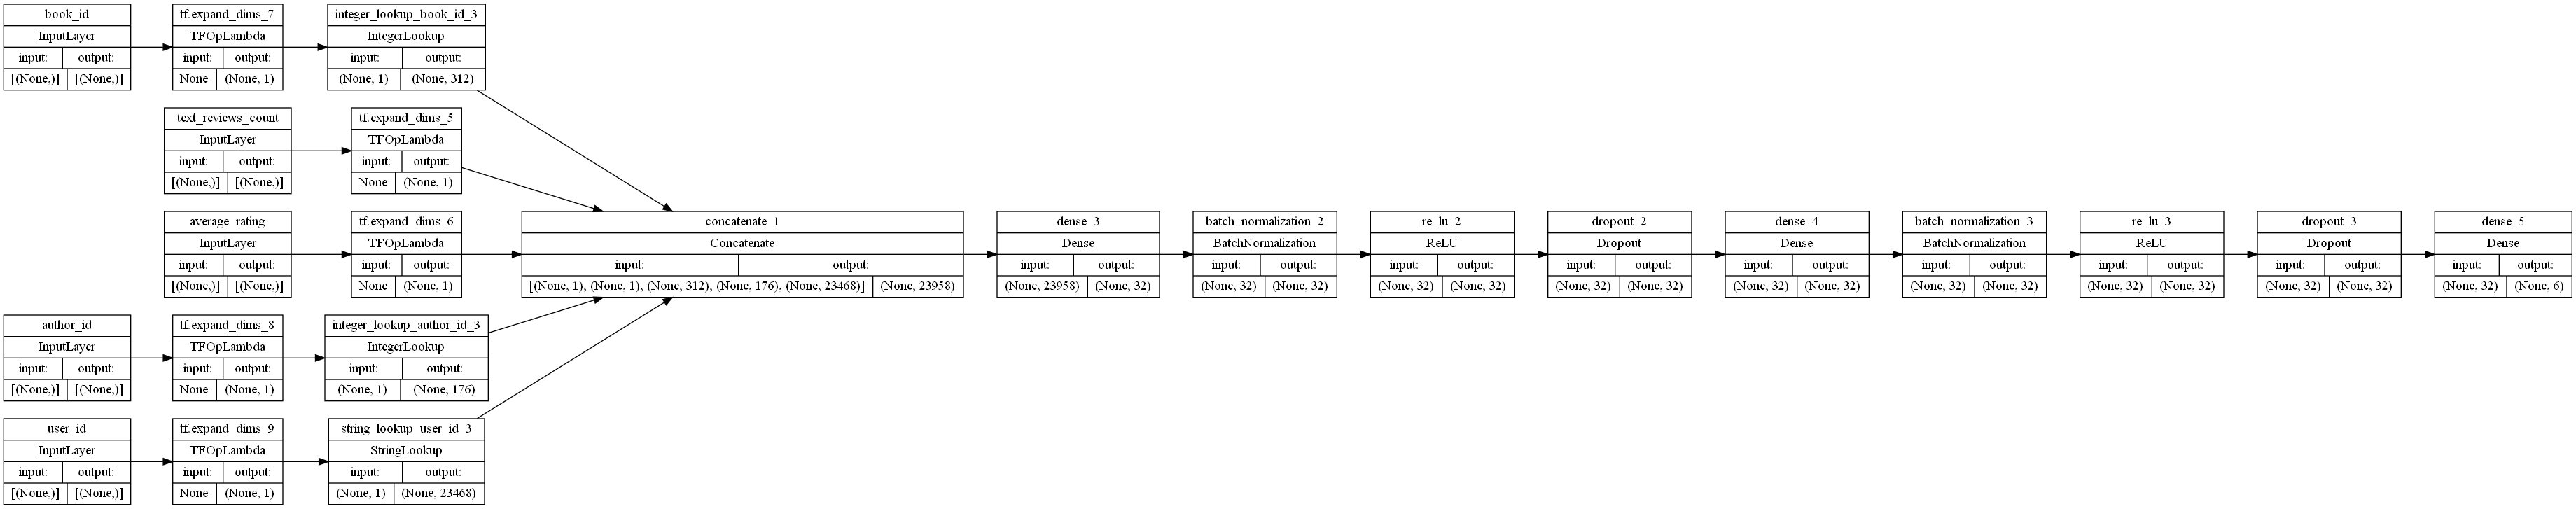

In [ ]:
def create_baseline_model():
    inputs = model_inputs
    features = model_features

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="baseline_model")
    return model


baseline_model = create_baseline_model()
plot_fn = os.path.join("./logs/model_plots/", "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")
keras.utils.plot_model(baseline_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(baseline_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/20
313/313 [==============================] - 79s 189ms/step - loss: 1.5790 - sparse_categorical_accuracy: 0.3095 - sparse_categorical_crossentropy: 1.5790
Epoch 2/20
313/313 [==============================] - 53s 170ms/step - loss: 1.4918 - sparse_categorical_accuracy: 0.3342 - sparse_categorical_crossentropy: 1.491821s - loss: 1.4935 - sparse_categ
Epoch 3/20
313/313 [==============================] - 50s 161ms/step - loss: 1.4779 - sparse_categorical_accuracy: 0.3487 - sparse_categorical_crossentropy: 1.4779
Epoch 4/20
313/313 [==============================] - 70s 224ms/step - loss: 1.4712 - sparse_categorical_accuracy: 0.3506 - sparse_categorical_crossentropy: 1.4712: 4s - loss: 1.4699 - sparse_categorical_accuracy: 0.3515 - sparse_categorical
Epoch 5/20
313/313 [==============================] - 69s 220ms/step - loss: 1.4661 - sparse_categorical_accuracy: 

(<keras.callbacks.History at 0x2679815d7f0>,
 [1.4472064971923828, 0.36775416135787964, 1.4472064971923828])

In [ ]:
baseline_model.save(os.path.join(MODEL_DIR, "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/baseline_model_20220127-202128\assets



Epoch 50/50
33/33 [==============================] - 3s 96ms/step - loss: 13.9775 - sparse_categorical_accuracy: 0.1705 - sparse_categorical_crossentropy: 1.7928

---

mit MAE funktionierts *überhaupt nicht*:

33/33 [==============================] - 6s 173ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.2904 - sparse_categorical_crossentropy: 1.8936

Model training finished

Test accuracy: 356.12. Test CategoricalCrossEntropy: 0.23%
(vermutlich werte umgekehrt)

Epoch 6/50
33/33 [==============================] - 15s 440ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.3038 - sparse_categorical_crossentropy: 1.8952

Model training finished
[3.561164140701294, 0.3306415379047394, 1.8279825448989868]

Epoch 43/50
33/33 [==============================] - 5s 143ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.8359
Model training finished
Test accuracy: 43.11%

Results w/ 8670 pieces of train data and baseline_model @ 15 epochs:
- loss: 0.7961 
- sparse_categorical_accuracy: 0.7035
- Test accuracy: 38.67 %

TODO: Datensatz fetching fixen, er hört sonst nach 16 epochs schon auf :o 8670/265er batches müsste für 32 reichen

## TODO andere Metrics, output ist ja nicht kategorisch, darf gern Regression sein, oder?

Learnings:
- eigentlich Klassifiziere ich gerade folgendes:
  - Gegeben Review mit Title, Beschreibung, Text, UserID, Author, etc. --> prädiziere die Bewertung von 0-5
  - (eigentlich recht easy)

- was ich für eine Recommendation bräuchte (-> Ranking)
- wäre eine prädizierte Bewertung **auf Basis der UserID** und Anhand der Buchfeatures Beschreibung, Titel, Author, etc.
- Dann "einfach" für alle Bücher prädizieren und top K Ergebnisse liefern --> MAP@k, Precision@k
  

wie im TF Tutorial beschrieben:
1. Candidate Model: --> Bücher --> Features
2. Query Model: --> Suchanfrage --> UserModel --> UserID
   - nicht ganz klar, wo die user-bewertungen jetzt konkret rein sollten..

RS-Tasks:
- *item rating prediction (regression)* [42]
- click-through rate prediction (binary classification) [11, 16]
- user behavior prediction (multi-class classification) [59], and
- *item retrieval (clustering)* [10].

In [ ]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


---
## Experiment 2: Wide & Deep model
In the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different representations.



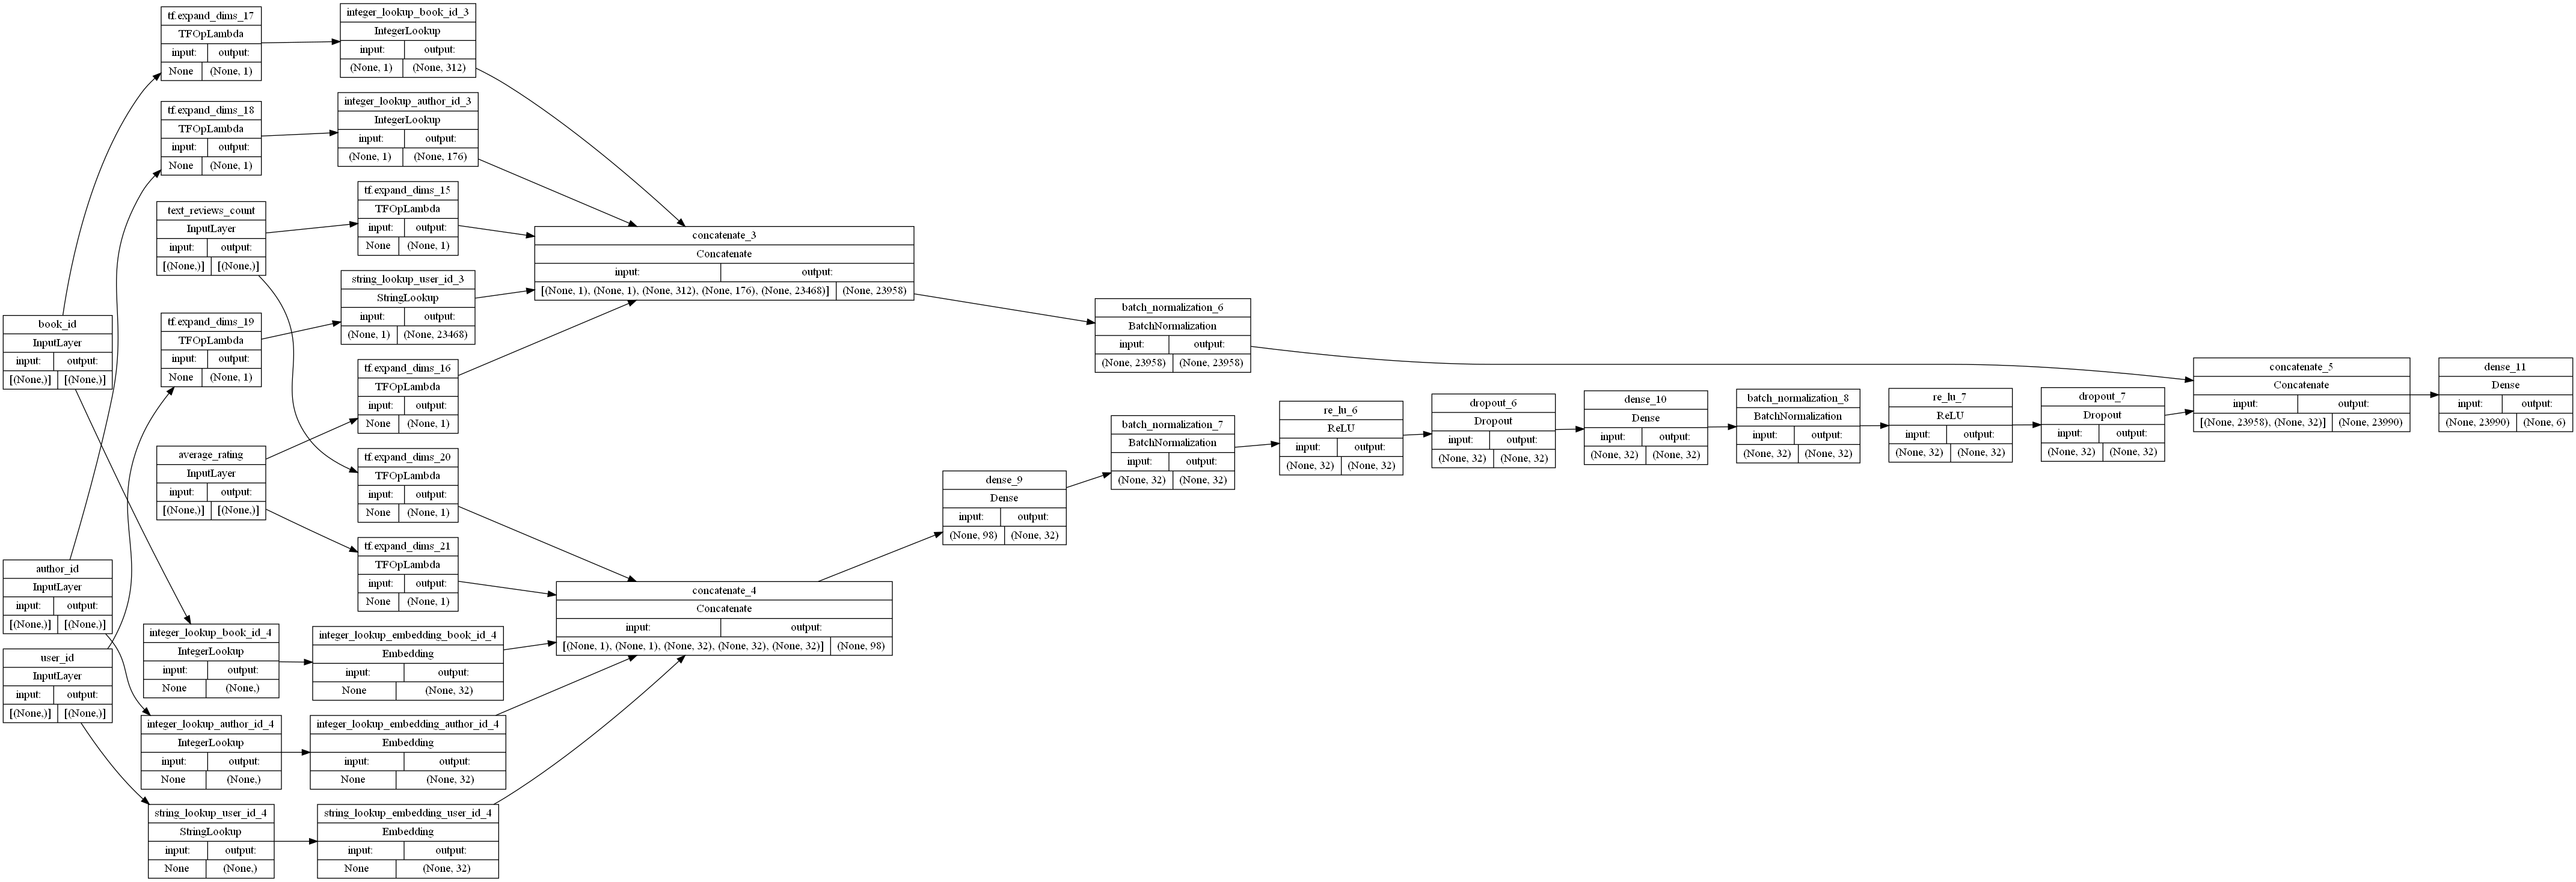

In [ ]:
def create_wide_and_deep_model():

    inputs = model_inputs
    wide = model_features
    wide = layers.BatchNormalization()(wide)

    deep = embedded_features
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs, name="wide_and_deep_model")
    return model


wide_and_deep_model = create_wide_and_deep_model()
plot_fn = os.path.join("./logs/model_plots/", "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(wide_and_deep_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(wide_and_deep_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/20


C:\Users\simon\anaconda3\envs\ds-project\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['review_text', 'title', 'description'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


313/313 [==============================] - 38s 101ms/step - loss: 1.4260 - sparse_categorical_accuracy: 0.3799 - sparse_categorical_crossentropy: 1.4260
Epoch 2/20
313/313 [==============================] - 33s 104ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.4937 - sparse_categorical_crossentropy: 1.2619
Epoch 3/20
313/313 [==============================] - 31s 98ms/step - loss: 1.1284 - sparse_categorical_accuracy: 0.5741 - sparse_categorical_crossentropy: 1.1284
Epoch 4/20
313/313 [==============================] - 36s 114ms/step - loss: 1.0114 - sparse_categorical_accuracy: 0.6335 - sparse_categorical_crossentropy: 1.0114
Epoch 5/20
313/313 [==============================] - 33s 107ms/step - loss: 0.9125 - sparse_categorical_accuracy: 0.6750 - sparse_categorical_crossentropy: 0.9125
Epoch 6/20
313/313 [==============================] - 33s 106ms/step - loss: 0.8321 - sparse_categorical_accuracy: 0.7000 - sparse_categorical_crossentropy: 0.8321
Epoch 7/20
313/313 [========

(<keras.callbacks.History at 0x267b48fa6d0>,
 [4.644235610961914, 0.2708769738674164, 4.644235610961914])

In [ ]:
wide_and_deep_model.save(os.path.join(MODEL_DIR, "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/wide_and_deep_model_20220127-203343\assets


---
## Experiment 3: Deep & Cross model
In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.

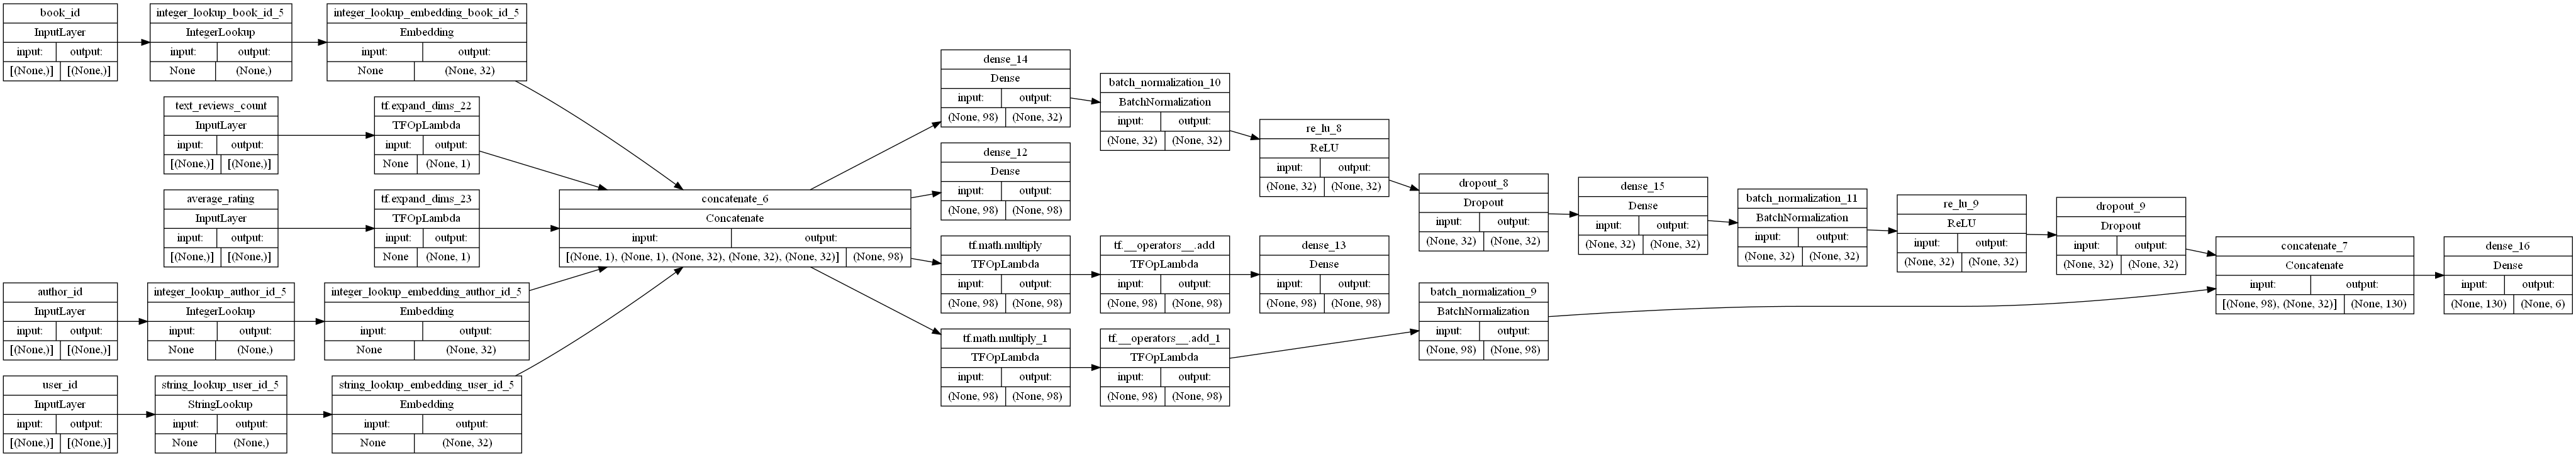

In [ ]:
def create_deep_and_cross_model():

    inputs = model_inputs
    x0 = embedded_features

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs, name="deep_and_cross_model")
    return model


deep_and_cross_model = create_deep_and_cross_model()
plot_fn = os.path.join("./logs/model_plots/", "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(deep_and_cross_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(deep_and_cross_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/20


C:\Users\simon\anaconda3\envs\ds-project\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['review_text', 'title', 'description'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


313/313 [==============================] - 20s 41ms/step - loss: 1.5633 - sparse_categorical_accuracy: 0.3415 - sparse_categorical_crossentropy: 1.5633
Epoch 2/20
313/313 [==============================] - 11s 37ms/step - loss: 1.3368 - sparse_categorical_accuracy: 0.4466 - sparse_categorical_crossentropy: 1.3368
Epoch 3/20
313/313 [==============================] - 13s 41ms/step - loss: 1.1510 - sparse_categorical_accuracy: 0.5423 - sparse_categorical_crossentropy: 1.1510
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 0.8754 - sparse_categorical_accuracy: 0.6516 - sparse_categorical_crossentropy: 0.8754
Epoch 5/20
313/313 [==============================] - 13s 42ms/step - loss: 0.7155 - sparse_categorical_accuracy: 0.7006 - sparse_categorical_crossentropy: 0.7155
Epoch 6/20
313/313 [==============================] - 18s 58ms/step - loss: 0.6057 - sparse_categorical_accuracy: 0.7385 - sparse_categorical_crossentropy: 0.6057
Epoch 7/20
313/313 [=============

(<keras.callbacks.History at 0x267c5fd4460>,
 [5.4389495849609375, 0.384116530418396, 5.4389495849609375])

In [ ]:
deep_and_cross_model.save(os.path.join(MODEL_DIR, "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/deep_and_cross_model_20220127-204018\assets
